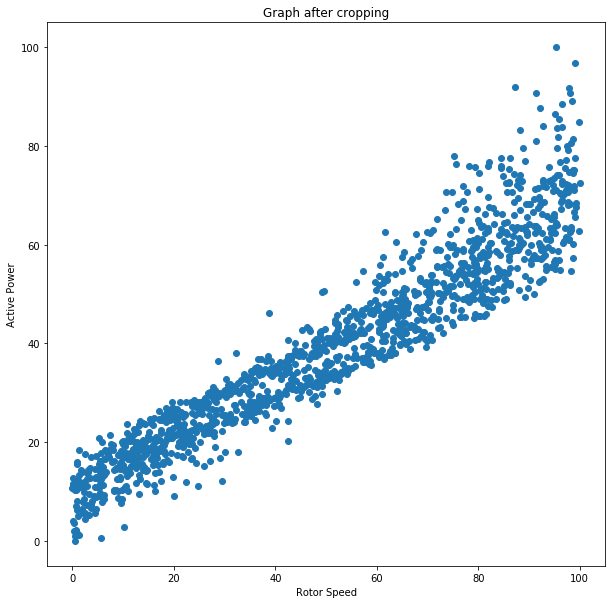

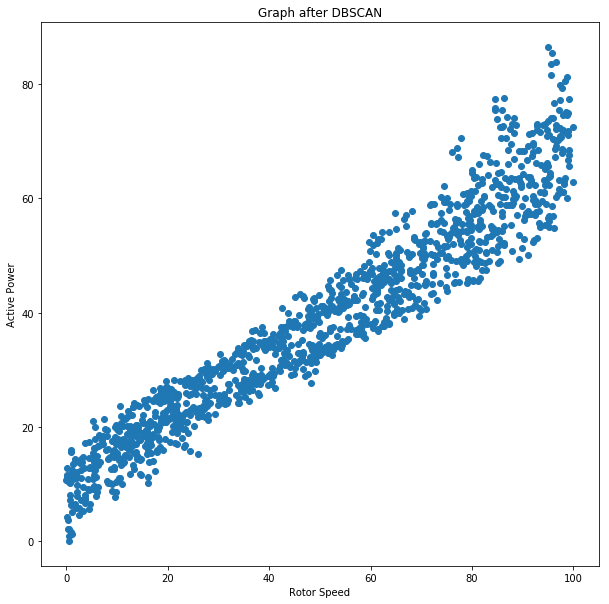

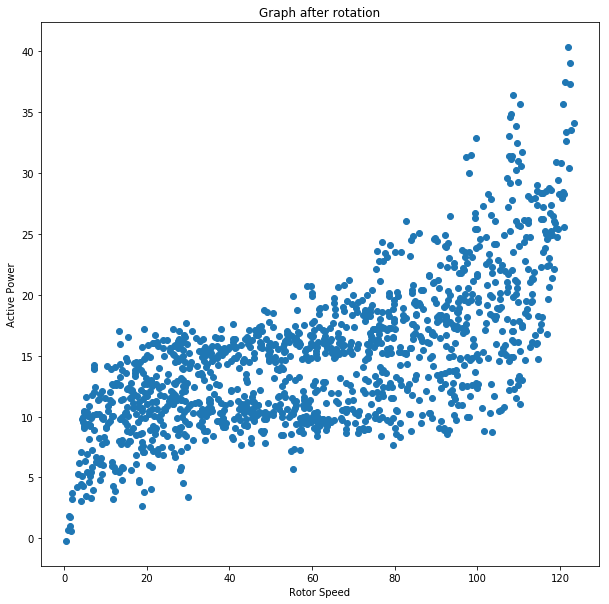

{'filePath': './RSvsAP/ScatterData_Burgula_B-509.csv',
 'machineType': 'DFIG',
 'negativeInstances': 13,
 'negativeScore:': -10.38258648503696,
 'positiveInstances': 0,
 'positiveScore': 0}

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as ss
from sklearn.cluster import DBSCAN

def main(
    filePath,
    yMinFilter=0,
    xMinFilter=21,
    xMaxFilter=25,
    turbineStateFilter=100,
    dbscanEps=2,
    dbscanMinSamples=4,
    rotationAngle=24,
    blockSize=10,
    plotGraph=False
):

    try:
        dataSet = pd.read_csv(filePath)

        # Filter values
        dataSet = dataSet[
            (dataSet['ActivePower'] > yMinFilter)
            & (dataSet['RotorSpeed'] > xMinFilter)
            & (dataSet['RotorSpeed'] < xMaxFilter)
            & (dataSet['TurbineState'] == turbineStateFilter)
        ]

        # Normalize Data
        minActivePower = dataSet['ActivePower'].min()
        minRotorSpeed = dataSet['RotorSpeed'].min()
        maxActivePower = dataSet['ActivePower'].max()
        maxRotorSpeed = dataSet['RotorSpeed'].max()

        dataSet['scaledActivePower'] = ((dataSet['ActivePower'] - minActivePower) * 100) / (maxActivePower - minActivePower)
        dataSet['scaledRotorSpeed'] = ((dataSet['RotorSpeed'] - minRotorSpeed) * 100) / (maxRotorSpeed - minRotorSpeed)

        # Cluster for errors
        dataSet['dbscanLabel'] = DBSCAN(eps=dbscanEps, min_samples=dbscanMinSamples).fit_predict(dataSet[['scaledRotorSpeed', 'scaledActivePower']])

        # Plot Data
        if plotGraph:
            plt.figure(figsize=(10, 10))
            plt.title('Graph after cropping')
            plt.xlabel('Rotor Speed')
            plt.ylabel('Active Power')
            plt.scatter(dataSet['scaledRotorSpeed'], dataSet['scaledActivePower'])
            plt.show()


        # Additional Filtering
        dataSet = dataSet[
            (dataSet['dbscanLabel'] != -1)
        ]

        # Plot Data
        if plotGraph:
            plt.figure(figsize=(10, 10))
            plt.title('Graph after DBSCAN')
            plt.xlabel('Rotor Speed')
            plt.ylabel('Active Power')
            plt.scatter(dataSet['scaledRotorSpeed'], dataSet['scaledActivePower'])
            plt.show()

        # Rotate
        theta = rotationAngle
        rotMatrix = np.array([
            [np.cos((np.pi * theta) / 180), -np.sin((np.pi * theta) / 180)],
            [np.sin((np.pi * theta) / 180), np.cos((np.pi * theta) / 180)]
        ])
        dataSet['rotatedRotorSpeed'] = 0
        dataSet['rotatedActivePower'] = 0
        dataSet[['rotatedRotorSpeed', 'rotatedActivePower']] = np.dot(dataSet[['scaledRotorSpeed', 'scaledActivePower']], rotMatrix)


        # Plot Data
        if plotGraph:
            plt.figure(figsize=(10, 10))
            plt.title('Graph after rotation')
            plt.xlabel('Rotor Speed')
            plt.ylabel('Active Power')
            plt.scatter(dataSet['rotatedRotorSpeed'], dataSet['rotatedActivePower'])
            plt.show()


        # Calculate the Statistic
        positiveScore = 0
        positiveInstances = 0
        negativeScore = 0
        negativeInstances = 0

        block = [dataSet['rotatedRotorSpeed'].min(), dataSet['rotatedRotorSpeed'].min() + blockSize]
        while block[0] < dataSet['rotatedRotorSpeed'].max():
            kurtScore = ss.kurtosis(dataSet[
                (dataSet['rotatedRotorSpeed'] > block[0])
                & (dataSet['rotatedRotorSpeed'] <= block[1])
            ]['rotatedActivePower'])

            if kurtScore < 0:
                negativeScore = negativeScore + kurtScore
                negativeInstances = negativeInstances + 1
            else:
                positiveScore = positiveScore + kurtScore
                positiveInstances = positiveInstances + 1

            block[0] = block[1]
            block[1] = block[1] + blockSize
    except Exception as e:
        return {
            'error': e
        }
            
    return {
        'filePath': filePath,
        'machineType': 'DFIG',
        'positiveInstances': positiveInstances,
        'negativeInstances': negativeInstances,
        'positiveScore': positiveScore,
        'negativeScore:': negativeScore
    }

    
main('./RSvsAP/ScatterData_Burgula_B-509.csv', plotGraph=True)